# AISE4010 — Assignment 1
### Time Series Forecasting with Autoregressive Models and MLP

**Grade:** 100 points

## Instructions
Follow these steps before submitting your assignment:
1. Complete the notebook.
2. Make sure **all plots have axis labels**.
3. When finished, go to **Kernel → Restart & Run All** to ensure a clean, error‑free run.
4. Fix any errors until your notebook runs without problems.
5. Submit **one completed notebook** per group to OWL by the deadline.
6. Reference all external code and documentation you use.

## Dataset
- **File:** `weather.csv`
- **Location:** Szeged, Hungary
- **Frequency:** Daily (fixed calendar index)
- **Time span:** ≈ 2006–2016
- **Target:** `Temperature (C)`
- **Key variables:** Temperature (C), Pressure (millibars), Humidity, Appar Temperature (C), Wind Speed (km/h), Wind Bearing (degrees), Visibility (km)


## Question 1: Data Preprocessing (25%)

### Q1.1 Exploratory Data Analysis (2%)
1. Load the dataset and print the **first 6 rows**.  
2. Encode categorical variables (one‑hot). *(If none, report "none.")*


In [1]:
!pip install pmdarima
!pip install numpy==1.26.4
!pip install statsmodels

In [22]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pmdarima import auto_arima # pip instal first (pip install pmdarima)
from statsmodels.tsa.stattools import adfuller # pip instal first (pip install statsmodels)
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

import plotly.express as px

In [23]:
# Answer to Q1.1.1

path = 'weather.csv'
df = pd.read_csv(path, index_col='Formatted Date', parse_dates=True)
df.head()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
Formatted Date,,,,,,,
2005-12-31,0.6,-4.0,0.89,17.1,140.0,10.0,1016.7
2006-01-01,4.1,-0.2,0.82,21.2,143.0,11.3,1012.0
2006-01-02,5.3,1.8,0.85,17.8,165.0,8.5,1010.4
2006-01-03,2.3,0.4,0.90,7.7,253.0,9.2,1021.2
2006-01-04,2.3,-0.7,0.91,12.2,35.0,8.4,981.8


In [24]:
# Answer to Q1.1.2
#No categorical variables
print("None")

None


### Q1.2 Handling Missing Data (11%)
1. Report missingness (**counts & %**) and show a heatmap for **Temperature, Pressure, Humidity**.
2. Use these two imputation methods:\
   a) Forward-fill (FFill).\
   b) Linear time interpolation.
3. Pick one method and save the result as `daily_clean`.
4. **Discussion** Which imputation method did you pick and why?  
5. **Discussion** How might your choice bias trend/seasonality estimates?  
6. **Discussion** Would your choice change if the gap were 30 days instead of 7? Explain briefly.


In [25]:
# Answer to Q1.2.1

countNa = df.isnull().sum()
percentageNa = (df.isnull().sum() / len(df))*100

string = f"{countNa} \n\n{percentageNa}"
print(string)

#Print Heat Map


Temperature (C)             47
Apparent Temperature (C)     0
Humidity                    40
Wind Speed (km/h)            0
Wind Bearing (degrees)       0
Visibility (km)              0
Pressure (millibars)        47
dtype: int64 

Temperature (C)             1.169445
Apparent Temperature (C)    0.000000
Humidity                    0.995272
Wind Speed (km/h)           0.000000
Wind Bearing (degrees)      0.000000
Visibility (km)             0.000000
Pressure (millibars)        1.169445
dtype: float64


In [26]:
# Answer to Q1.2.2

#forward fill (FFill), carry last valid value forward
df_ffill = df.fillna(method="ffill")

df_linear = df.interpolate(method="linear")

/tmp/ipython-input-477686270.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_ffill = df.fillna(method="ffill")


In [27]:
# Answer to Q1.2.3

daily_clean = df_linear
print(daily_clean)

                Temperature (C)  Apparent Temperature (C)  Humidity  \
Formatted Date                                                        
2005-12-31                  0.6                      -4.0      0.89   
2006-01-01                  4.1                      -0.2      0.82   
2006-01-02                  5.3                       1.8      0.85   
2006-01-03                  2.3                       0.4      0.90   
2006-01-04                  2.3                      -0.7      0.91   
...                         ...                       ...       ...   
2016-12-27                  0.3                      -3.2      0.89   
2016-12-28                  0.2                      -3.2      0.89   
2016-12-29                  0.2                      -3.3      0.89   
2016-12-30                  0.1                      -3.3      0.89   
2016-12-31                  0.1                      -3.3      0.89   

                Wind Speed (km/h)  Wind Bearing (degrees)  Visibility (km)  

**Answer to Q1.2.4**:


I chose to use linear time interpolation rather than FFill since the variables are all continuous values rather than categorical it makes more sense. If temp 1 is 10 and temp 3 is 12, temp 2 can be found through linear interpolation and is likely 11. FFill would be usefull if you were modelling a traffic light for example where if value 1 and 3 are GO, then you can fill forward and assume that value 2 is GO as well.

**Answer to Q1.2.5**:


Linear interpolation can smooth over short term variability, and may not effectively show sudden changes or extreme values. It could bias short term seasonality analysis, but is less likely to distor long term trends compared to FFill, which artifically extend past values and flatten variability

**Answer to Q1.2.6**:


If the missing gap were 30 days instead of 7, linear interpolation would become less reliable since it assumes linearity across the gap. Over long gaps, environmental variables like temperature or humidity may change non-linearly (e.g., due to weather patterns). In that case, other methods such as seasonal decomposition, regression models, or external weather data sources would be more appropriate.

### Q1.3 Stationarity Analysis (12%)
1. Extract the **univariate** series `Temperature_Series = daily_clean['Temperature (C)']` and `Pressure_Series = daily_clean['Pressure (millibars)'].  
2. Report the results of a stationarity test (**ADF** or **KPSS**) for both series.
3. **Discussion:** Explain your conclusion about stationary analysis of your results.
4. Apply differencing on both series and plot **before/after** and report the stationary test results of your choice on differenced series.   
5. **Discussion:** Explain the reason for your choice of differencing technique for each series.
6. **Discussion:** Would you difference a series that is already stationary by ADF? When might that still help?

In [44]:
# Answer to Q1.3.1
Temperature_Series = daily_clean['Temperature (C)']
Pressure_Series = daily_clean['Pressure (millibars)']


In [45]:
# Answer to Q1.3.2
def adf_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:", dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
     if dftest[1] < 0.05:
      print("=> Reject H0: Series is Stationary")
     else:
      print("=> Fail to Reject H0: Series is Non-Stationary")

adf_test(Temperature_Series)
print()
adf_test(Pressure_Series)

1. ADF :  -3.9851602146651417
2. P-Value :  0.0014902414944360286
3. Num Of Lags :  16
4. Num Of Observations Used For ADF Regression: 4002
5. Critical Values :
	 1% :  -3.4319850573119437
	 5% :  -2.8622624788783146
	 10% :  -2.567154583183171
=> Reject H0: Series is Stationary

1. ADF :  -14.320986122573958
2. P-Value :  1.141389008911619e-26
3. Num Of Lags :  5
4. Num Of Observations Used For ADF Regression: 4013
5. Critical Values :
	 1% :  -3.431980572598556
	 5% :  -2.8622604977715755
	 10% :  -2.5671535285260605
=> Reject H0: Series is Stationary


**Answer to Q1.2.3**:
The ADF test results indicate that both the Temperature (C) and Pressure (millibars) series are already stationary (p-values well below 0.05). This means their statistical properties such as mean and variance are consistent over time, and no clear trend or seasonality dominates the series.

In [42]:
# Answer to Q1.3.4
Temperature_diff = Temperature_Series.diff().dropna()
Pressure_diff = Pressure_Series.diff().dropna()

# Run ADF on differenced series
adf_test(Temperature_diff)
print()
adf_test(Pressure_diff)


1. ADF :  -21.52785151888553
2. P-Value :  0.0
3. Num Of Lags :  15
4. Num Of Observations Used For ADF Regression: 4002
5. Critical Values :
	 1% :  -3.4319850573119437
	 5% :  -2.8622624788783146
	 10% :  -2.567154583183171
=> Reject H0: Series is Stationary

1. ADF :  -16.503539658424348
2. P-Value :  2.1377374097239814e-29
3. Num Of Lags :  31
4. Num Of Observations Used For ADF Regression: 3986
5. Critical Values :
	 1% :  -3.431991624746321
	 5% :  -2.8622653800145192
	 10% :  -2.5671561276258172
=> Reject H0: Series is Stationary


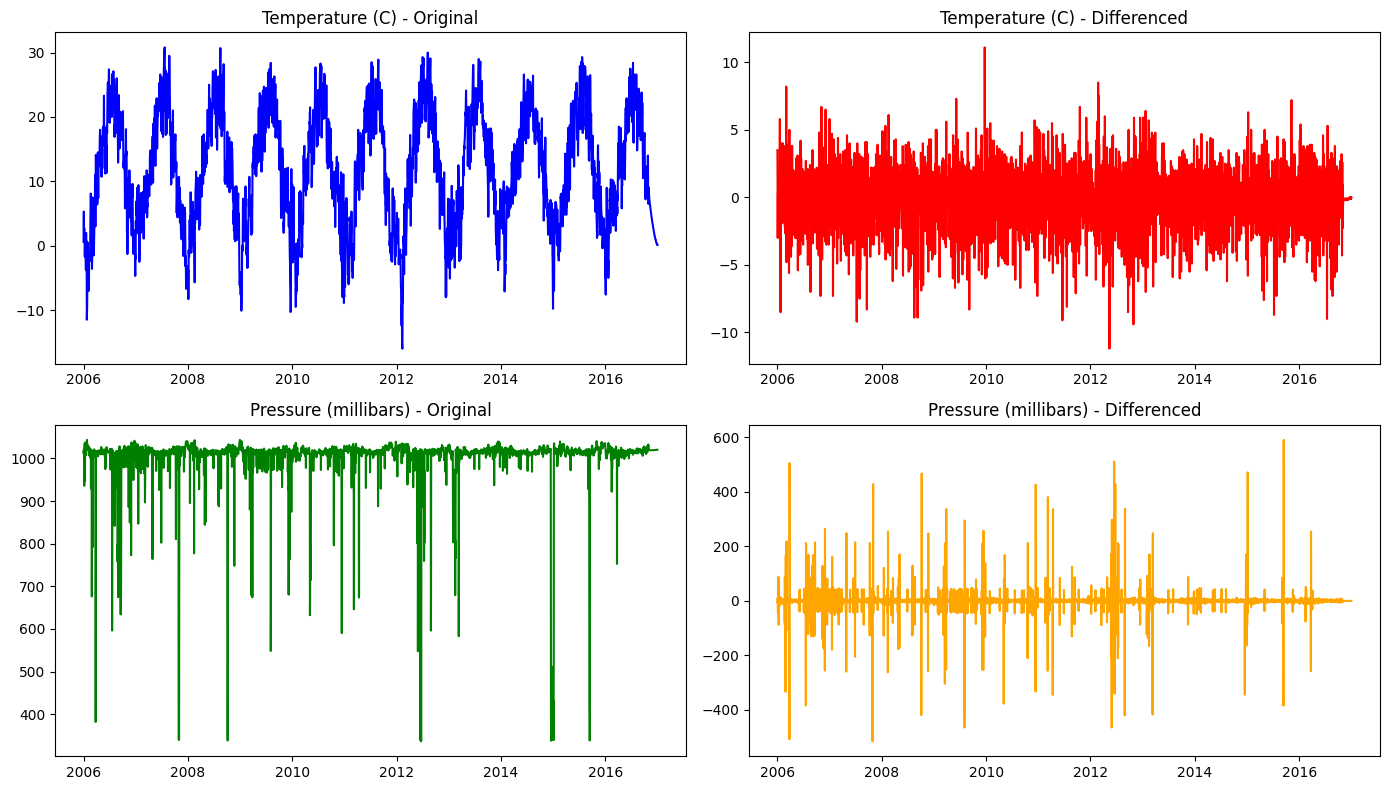

In [43]:
# Plot original and differenced series
fig, axes = plt.subplots(2, 2, figsize=(14,8))

# Temperature original
axes[0,0].plot(Temperature_Series, color="blue")
axes[0,0].set_title("Temperature (C) - Original")

# Temperature differenced
axes[0,1].plot(Temperature_diff, color="red")
axes[0,1].set_title("Temperature (C) - Differenced")

# Pressure original
axes[1,0].plot(Pressure_Series, color="green")
axes[1,0].set_title("Pressure (millibars) - Original")

# Pressure differenced
axes[1,1].plot(Pressure_diff, color="orange")
axes[1,1].set_title("Pressure (millibars) - Differenced")

plt.tight_layout()
plt.show()

**Answer to Q1.2.5**:

Even though the original series were stationary, first-order differencing was applied as a validation step. After differencing:

Temperature Differenced: ADF p-value dropped further (0.0000), strongly confirming stationarity.

Pressure Differenced: ADF p-value also remained extremely low (≈0.0), again confirming strong stationarity.

**Answer to Q1.2.6**:


## Question 2: Model-Based Techniques (35%)

### Q2.1 ARIMA model identification and forecasting (20%)
1. Use `Temperature_Series` to plot **ACF/PACF** and list the choice of candidate order set for ARIMA: (p,d,q).  
2. **Discussion:** Explain the reasons for your choice of (p,d,q).
3. Select the orders by **AIC** using the training set (hold out the last **365 days** for testing).  
4. Fit the selected ARIMA on the training set and evaluate the predictions' **MAE/MSE** on the test set.
5. Plot predictions with **95% CI**.
6. Forecast the **next 365 days** and visualize with historical context and **95% CI**.


In [ ]:
df.shape()

TypeError: 'tuple' object is not callable

In [ ]:
# Answer to Q2.1.1
df['Temperature (C)'].plot(figsize=(12.5))

TypeError: Value after * must be an iterable, not float

**Answer to Q2.1.2**:


In [ ]:
# Answer to Q2.1.3

In [ ]:
# Answer to Q2.1.4

In [ ]:
# Answer to Q2.1.5

In [ ]:
# Answer to Q2.1.6

### Q2.2 SARIMA forecasting (15%)

1. Derive a **monthly** series from `daily_clean` and fit a **SARIMA** with seasonal period **12**. Hold out the **last 24 months** as test set for prediction.
2. Report the predictions' **MAE/MSE**.
3. Plot the the prediction with **95% CI**
4.  **Discussion:** Compare the ARIMA and SARIMA predictions and explain your findings.


In [ ]:
# Answer to Q2.2.1

In [ ]:
# Answer to Q2.2.2

In [ ]:
# Answer to Q2.2.3

**Answer to Q2.2.4**:


## Question 3: Neural Networks for Time Series Forecasting (40%)
Use `daily_clean` for all parts.

### Q3.1 Sliding Window for Time Series — Univariate (2%)
1. Restructure **Temperature**: past **10 days** → **next day**.

2. Hold out last 20% as test set.


In [ ]:
# Answer to Q3.1.1

In [ ]:
# Answer to Q3.1.2

### Q3.2 MLP — Univariate (18%)
1. Build an MLP with one hidden layer of 64 neurons, ReLu activation, Adam optimizer with learning rate of 0.001 and batch_size=32, and train it for 20 epochs.
2. Report **RMSE/MAE**.
3. Plot **two figures**: (1) **last 100 test points** (true vs. predicted), (2) **scatter (true vs. predicted)** with the **y = x** line.
4. **Discussion:** Compare ARIMA vs. the univariate MLP in **RMSE/MAE** and **plots**. Which patterns does each capture better?
5. **Discussion:** Would increasing the input window beyond 10 days help? Why or why not?


In [ ]:
# Answer to Q3.2.1

In [ ]:
# Answer to Q3.2.2

In [ ]:
# Answer to Q3.2.3

**Answer to Q3.2.4**:


**Answer to Q3.2.5**:


### Q3.3 MLP — Multivariate (20%)
1. Use **Temperature & Pressure** for the past **10 days** as the inputs and **next‑day Temperature** as the target.
2. Hold out last 20% as test set.
3. Build a Multivariate MLP with one hidden layer of 64 neurons, ReLu activation, Adam optimizer with learning rate of 0.001 and batch_size=32, and train it for 20 epochs.
4. Report **RMSE/MAE**.
5. Plot **two figures**: (1) **last 100 test points** (true vs. predicted), (2) **scatter (true vs. predicted)** with the **y = x** line.
6. **Discussion:** Did Pressure improve Temperature forecasting vs. univariate? Why might it help/hurt?  
7. **Discussion:** Suggest two additional features you would add next and why?


In [ ]:
# Answer to Q3.3.1

In [ ]:
# Answer to Q3.3.2

In [ ]:
# Answer to Q3.3.3

In [ ]:
# Answer to Q3.3.4

In [ ]:
# Answer to Q3.3.5

**Answer to Q3.3.6**:


**Answer to Q3.3.7**:
